In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$

### Representing complex numbers

To represent the complex numbers, I will use an array of two float, where the first element represents the real part and the second element the imaginary part.

In [17]:
def square(x):
    result = [0, 0]

    result[0] = x[0]**2 - x[1]**2
    result[1] = 2 * x[0] * x[1]

    return result


def compute(c, z):
    """Compute z^2 + c"""
    z_square = square(z)
    return [c[0] + z_square[0] , c[1] + z_square[1]]


def isInMandelbrotSet(c, z=[0, 0], max_iter=1000, n=0) -> bool:
    if z[0]**2 + z[1]**2 > 4:
        return False
    
    if n==max_iter:
        return True

    return isInMandelbrotSet(c, compute(c, z), max_iter, n+1)


In [18]:
print(f"Is [-1,0] in the set?: {isInMandelbrotSet([-1, 0])}")  # should be true
print(f"Is [1,0] in the set?: {isInMandelbrotSet([1, 0])}")  # should be false

Is [-1,0] in the set?: True
Is [1,0] in the set?: False


### Creating a dataset

In [19]:
# Define the range for the real and imaginary parts
real_range = np.linspace(-2, 1, 50)
imag_range = np.linspace(-1.5, 1.5, 50)

data = []
for a in real_range:
    for b in imag_range:
        c = [a, b]
        is_in_set = isInMandelbrotSet(c)
        data.append({
            'real': a,
            'imag': b,
            'in_mandelbrot_set': is_in_set
        })

df = pd.DataFrame(data)

In [20]:
df

,real,imag,in_mandelbrot_set
0,-2.0,-1.500000,False
1,-2.0,-1.438776,False
2,-2.0,-1.377551,False
3,-2.0,-1.316327,False
4,-2.0,-1.255102,False
...,...,...,...
2495,1.0,1.255102,False
2496,1.0,1.316327,False
2497,1.0,1.377551,False
2498,1.0,1.438776,False


As we can see, the dataset is heavily imbalanced. It is very important to remember this, because it will affect the way we measure the performance pf the model and the way we split the dataset.

In [21]:
df['in_mandelbrot_set'].value_counts()

in_mandelbrot_set
False    2094
True      406
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["in_mandelbrot_set"])
y = df["in_mandelbrot_set"]

# Using stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)


### Neural Network

In [23]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layers=3):
        super().__init__()
        
        layers = [
            nn.Linear(2, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        return self.sigmoid_layer(x)

### Visualization Function

In [24]:
def plot_decision_boundary(model, epoch, real_res=400, imag_res=400):
    """
    Generates and saves an image of the model's decision boundary.
    """
    # Define the range for the real and imaginary parts
    real_range = np.linspace(-2, 1, real_res)
    imag_range = np.linspace(-1.5, 1.5, imag_res)
    
    # Create a grid of points
    grid = []
    for a in real_range:
        for b in imag_range:
            grid.append([a, b])
            
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Get the model's predictions (probabilities)
        predictions = model(grid_tensor)
    
    # Reshape the predictions back into a 2D image format
    image_data = predictions.numpy().reshape((real_res, imag_res))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data.T, extent=[-2, 1, -1.5, 1.5], origin='lower', cmap='hot')
    plt.title(f'Decision Boundary at Epoch {epoch+1}')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    
    # Save the figure to a file
    filename = f"images/mandelbrot_epoch_{epoch+1}.png"
    plt.savefig(filename)
    # plt.close()
    print(f"Saved image: {filename}")

### Training Loop

In [25]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCELoss(), visualize=False):

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
        
        # Plotting the set
        if visualize:
            if (epoch + 1) % 1 == 0:    # Every epoch
                plot_decision_boundary(model, epoch)

    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

def test(model, X_test, y_test, threshold=0.5):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        y_prob_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_prob_tensor > threshold).float()

        y_true_np = y_test_tensor.numpy()
        y_pred_np = y_pred.numpy()
        y_prob_np = y_prob_tensor.numpy()

        # Calculate metrics
        auc = roc_auc_score(y_true_np, y_prob_np)
        print(f"Test AUC: {auc:.4f}\n")
        
        accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_test_tensor.numpy(), y_pred.numpy()))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()))

        f1 = f1_score(y_true_np, y_pred_np, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "auc": auc,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
    
    return report

### Choosing Model

We will use the validation set to test the different models and choose which one we want to use.

Training model: 1_hidden_layer
Epoch: 1, Train Loss: 0.6871118105159086, Val Loss: 0.6621189959843954
Epoch: 2, Train Loss: 0.633860392850988, Val Loss: 0.6068371828397116
Epoch: 3, Train Loss: 0.573974230149213, Val Loss: 0.54348393201828
Epoch: 4, Train Loss: 0.5101064523528603, Val Loss: 0.4819408448537191
Epoch: 5, Train Loss: 0.4526445003116832, Val Loss: 0.43069960514704386
Epoch: 6, Train Loss: 0.40735948765979096, Val Loss: 0.3930176568031311
Epoch: 7, Train Loss: 0.37564582425005294, Val Loss: 0.36738744099934895
Epoch: 8, Train Loss: 0.35445135607438927, Val Loss: 0.35161210457483927
Epoch: 9, Train Loss: 0.34099733091452544, Val Loss: 0.34104886452356975
Epoch: 10, Train Loss: 0.3311210092025645, Val Loss: 0.3325631618499756
Epoch: 11, Train Loss: 0.32256294685251574, Val Loss: 0.3247151835759481
Epoch: 12, Train Loss: 0.31434367844287087, Val Loss: 0.3168200214703878
Epoch: 13, Train Loss: 0.3060703322116066, Val Loss: 0.3087567861874898
Epoch: 14, Train Loss: 0.29772541545

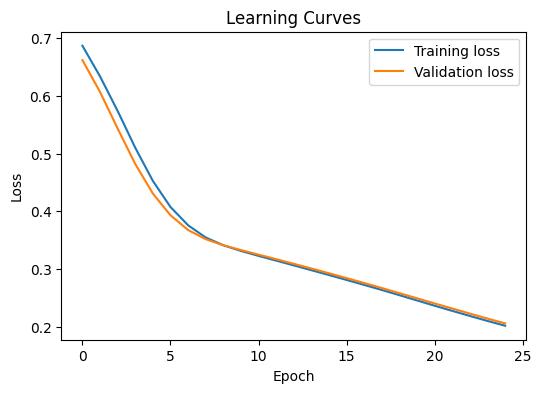

Test AUC: 0.9860

Test Accuracy: 0.8933

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       251
         1.0       1.00      0.35      0.52        49

    accuracy                           0.89       300
   macro avg       0.94      0.67      0.73       300
weighted avg       0.91      0.89      0.87       300

Confusion Matrix:
[[251   0]
 [ 32  17]]
Training model: 3_hidden_layers
Epoch: 1, Train Loss: 0.6720879654323354, Val Loss: 0.6422435847918192
Epoch: 2, Train Loss: 0.6069762123332304, Val Loss: 0.5701713975270589
Epoch: 3, Train Loss: 0.5176501724299263, Val Loss: 0.470645580291748
Epoch: 4, Train Loss: 0.4295682394153932, Val Loss: 0.4070442350705465
Epoch: 5, Train Loss: 0.3907983338832855, Val Loss: 0.3883477973937988
Epoch: 6, Train Loss: 0.3776318421784569, Val Loss: 0.37767101446787515
Epoch: 7, Train Loss: 0.36729825398501226, Val Loss: 0.3671596852938334
Epoch: 8, Train Loss: 0.35660684836261

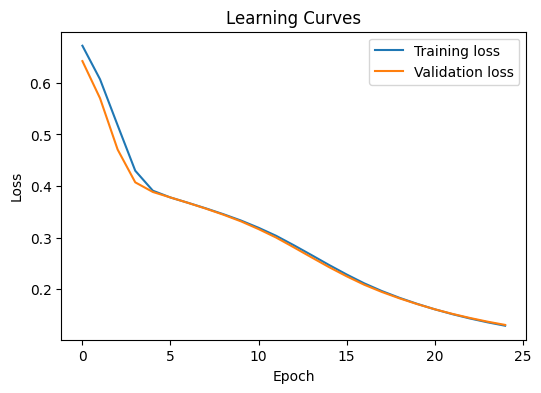

Test AUC: 0.9885

Test Accuracy: 0.9400

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       251
         1.0       0.83      0.80      0.81        49

    accuracy                           0.94       300
   macro avg       0.90      0.88      0.89       300
weighted avg       0.94      0.94      0.94       300

Confusion Matrix:
[[243   8]
 [ 10  39]]
Training model: 5_hidden_layers
Epoch: 1, Train Loss: 0.6667181845272289, Val Loss: 0.6539463798205057
Epoch: 2, Train Loss: 0.6328365276841557, Val Loss: 0.5961563674608866
Epoch: 3, Train Loss: 0.5073683895083034, Val Loss: 0.41522382736206054
Epoch: 4, Train Loss: 0.3937111806168276, Val Loss: 0.3861441906293233
Epoch: 5, Train Loss: 0.37591570203795155, Val Loss: 0.3721401826540629
Epoch: 6, Train Loss: 0.3599610195089789, Val Loss: 0.35626784324645994
Epoch: 7, Train Loss: 0.34139021955868776, Val Loss: 0.33749906222025555
Epoch: 8, Train Loss: 0.3195239707

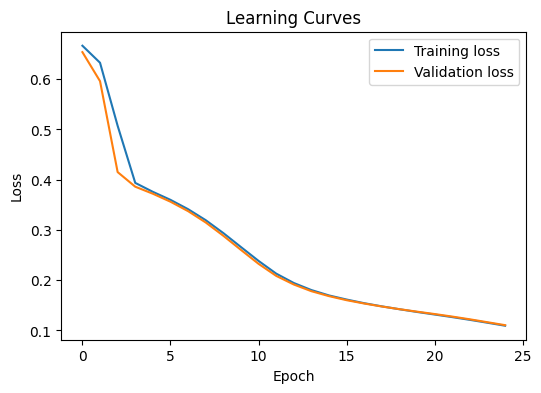

Test AUC: 0.9928

Test Accuracy: 0.9767

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       251
         1.0       0.92      0.94      0.93        49

    accuracy                           0.98       300
   macro avg       0.95      0.96      0.96       300
weighted avg       0.98      0.98      0.98       300

Confusion Matrix:
[[247   4]
 [  3  46]]
Training model: 7_hidden_layers
Epoch: 1, Train Loss: 0.6330636821073644, Val Loss: 0.6209471416473389
Epoch: 2, Train Loss: 0.605107625652762, Val Loss: 0.5831687672932943
Epoch: 3, Train Loss: 0.5227679148141076, Val Loss: 0.43457086086273194
Epoch: 4, Train Loss: 0.4083899152980131, Val Loss: 0.403234589099884
Epoch: 5, Train Loss: 0.3926710247993469, Val Loss: 0.3909804360071818
Epoch: 6, Train Loss: 0.3788930696249008, Val Loss: 0.3769638649622599
Epoch: 7, Train Loss: 0.36335782724268295, Val Loss: 0.3614289697011312
Epoch: 8, Train Loss: 0.346011140083565

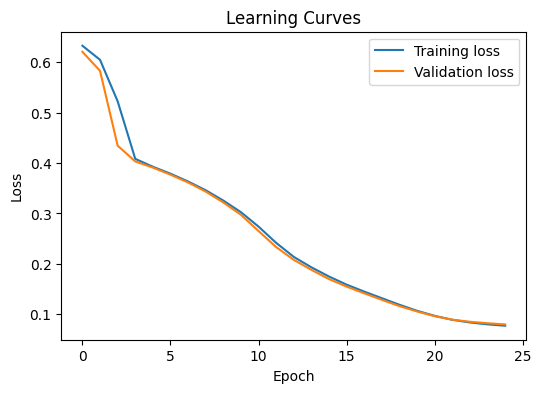

Test AUC: 0.9952

Test Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       251
         1.0       0.85      0.96      0.90        49

    accuracy                           0.97       300
   macro avg       0.92      0.96      0.94       300
weighted avg       0.97      0.97      0.97       300

Confusion Matrix:
[[243   8]
 [  2  47]]
Training model: 9_hidden_layers
Epoch: 1, Train Loss: 0.7035665405497832, Val Loss: 0.6846199067433675
Epoch: 2, Train Loss: 0.6636274926802691, Val Loss: 0.6367500909169515
Epoch: 3, Train Loss: 0.5590459789949305, Val Loss: 0.4276911528905233
Epoch: 4, Train Loss: 0.4050795030944488, Val Loss: 0.4031768131256104
Epoch: 5, Train Loss: 0.3918619293675703, Val Loss: 0.392266685962677
Epoch: 6, Train Loss: 0.38025206586893867, Val Loss: 0.3803697180747986
Epoch: 7, Train Loss: 0.3666373490586, Val Loss: 0.36632031440734864
Epoch: 8, Train Loss: 0.3510159182548523,

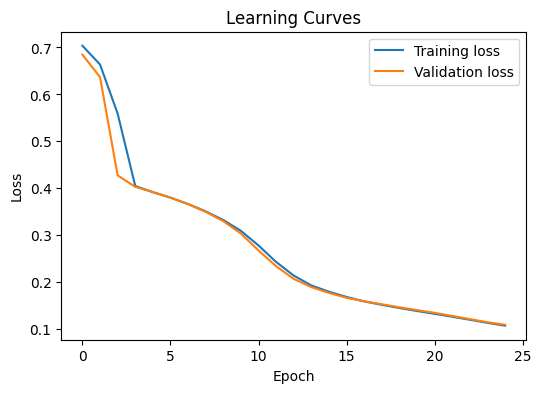

Test AUC: 0.9920

Test Accuracy: 0.9567

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       251
         1.0       0.82      0.94      0.88        49

    accuracy                           0.96       300
   macro avg       0.90      0.95      0.92       300
weighted avg       0.96      0.96      0.96       300

Confusion Matrix:
[[241  10]
 [  3  46]]


In [27]:
model_configs = {
    "1_hidden_layer": NeuralNet(num_hidden_layers=1),
    "3_hidden_layers": NeuralNet(num_hidden_layers=3),
    "5_hidden_layers": NeuralNet(num_hidden_layers=5),
    "7_hidden_layers": NeuralNet(num_hidden_layers=7),
    "9_hidden_layers": NeuralNet(num_hidden_layers=9),
}

results = {}

for name, model in model_configs.items():
    print(f"Training model: {name}")
    
    # Train the model
    trained_model = train(model, X_train, y_train, X_val, y_val, num_epoch=25)
    
    # Test the model and store the returned metrics
    results[name] = test(trained_model, X_val, y_val)

In [28]:
results_df = pd.DataFrame(results).T
results_df

,accuracy,f1_score_positive,auc,true_positives,false_positives,true_negatives,false_negatives
1_hidden_layer,0.893333,0.515152,0.986015,17.0,0.0,251.0,32.0
3_hidden_layers,0.940000,0.812500,0.988536,39.0,8.0,243.0,10.0
5_hidden_layers,0.976667,0.929293,0.992764,46.0,4.0,247.0,3.0
7_hidden_layers,0.966667,0.903846,0.995203,47.0,8.0,243.0,2.0
9_hidden_layers,0.956667,0.876190,0.991951,46.0,10.0,241.0,3.0


### Test the chosen model

Test it on the test set

Epoch: 1, Train Loss: 0.6186475774821113, Val Loss: 0.6021409201622009
Epoch: 2, Train Loss: 0.5629099955979515, Val Loss: 0.49946802536646523
Epoch: 3, Train Loss: 0.4291208407458137, Val Loss: 0.3914272999763489
Epoch: 4, Train Loss: 0.3784393753199016, Val Loss: 0.3747532725334167
Epoch: 5, Train Loss: 0.36068012020167184, Val Loss: 0.35783028999964395
Epoch: 6, Train Loss: 0.3405228744008962, Val Loss: 0.3372285556793213
Epoch: 7, Train Loss: 0.3161693994437947, Val Loss: 0.3120941130320231
Epoch: 8, Train Loss: 0.28773038091028436, Val Loss: 0.2827318513393402
Epoch: 9, Train Loss: 0.25696817732909144, Val Loss: 0.2521697417894999
Epoch: 10, Train Loss: 0.22936743932611803, Val Loss: 0.22623217225074768
Epoch: 11, Train Loss: 0.20696626799071535, Val Loss: 0.20430785059928894
Epoch: 12, Train Loss: 0.1881566974827472, Val Loss: 0.18706190705299378
Epoch: 13, Train Loss: 0.17301896450274132, Val Loss: 0.17206301510334016
Epoch: 14, Train Loss: 0.1589324049432488, Val Loss: 0.158912

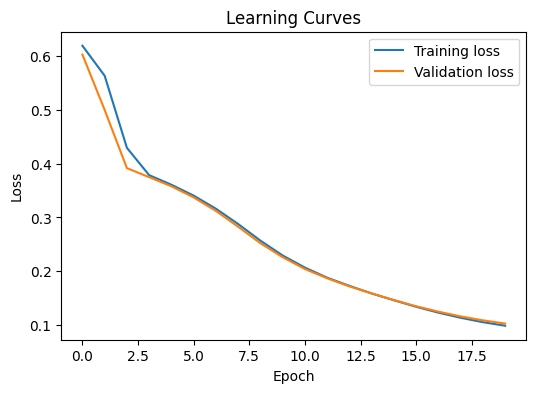

Test AUC: 0.9907

Test Accuracy: 0.9540

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       419
         1.0       0.81      0.94      0.87        81

    accuracy                           0.95       500
   macro avg       0.90      0.95      0.92       500
weighted avg       0.96      0.95      0.96       500

Confusion Matrix:
[[401  18]
 [  5  76]]


In [29]:
model = NeuralNet(num_hidden_layers=5)

model = train(model, X_train, y_train, X_val, y_val)
report = test(model, X_test, y_test)

### Visualization

--- Training and Generating Visualization ---
Epoch: 1, Train Loss: 0.7292735032474293, Val Loss: 0.7013057740529378
Saved image: images/mandelbrot_epoch_1.png
Epoch: 2, Train Loss: 0.6552081576515647, Val Loss: 0.585761551062266
Saved image: images/mandelbrot_epoch_2.png
Epoch: 3, Train Loss: 0.4840433980787502, Val Loss: 0.4065963379542033
Saved image: images/mandelbrot_epoch_3.png
Epoch: 4, Train Loss: 0.3882901590010699, Val Loss: 0.38280280590057375
Saved image: images/mandelbrot_epoch_4.png
Epoch: 5, Train Loss: 0.37061652527135963, Val Loss: 0.36824044307072956
Saved image: images/mandelbrot_epoch_5.png
Epoch: 6, Train Loss: 0.35404818559394163, Val Loss: 0.35224290132522584
Saved image: images/mandelbrot_epoch_6.png
Epoch: 7, Train Loss: 0.33575551567708745, Val Loss: 0.3343253151575724
Saved image: images/mandelbrot_epoch_7.png
Epoch: 8, Train Loss: 0.31553513132474004, Val Loss: 0.3142192999521891
Saved image: images/mandelbrot_epoch_8.png
Epoch: 9, Train Loss: 0.292883893742

/tmp/ipykernel_31583/3314600637.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6))


Saved image: images/mandelbrot_epoch_21.png
Epoch: 22, Train Loss: 0.10094083331525326, Val Loss: 0.1042320837577184
Saved image: images/mandelbrot_epoch_22.png
Epoch: 23, Train Loss: 0.09624923934393069, Val Loss: 0.09974704975883165
Saved image: images/mandelbrot_epoch_23.png
Epoch: 24, Train Loss: 0.09246446953319451, Val Loss: 0.09597782005866369
Saved image: images/mandelbrot_epoch_24.png
Epoch: 25, Train Loss: 0.08933116771280765, Val Loss: 0.09276235779126485
Saved image: images/mandelbrot_epoch_25.png


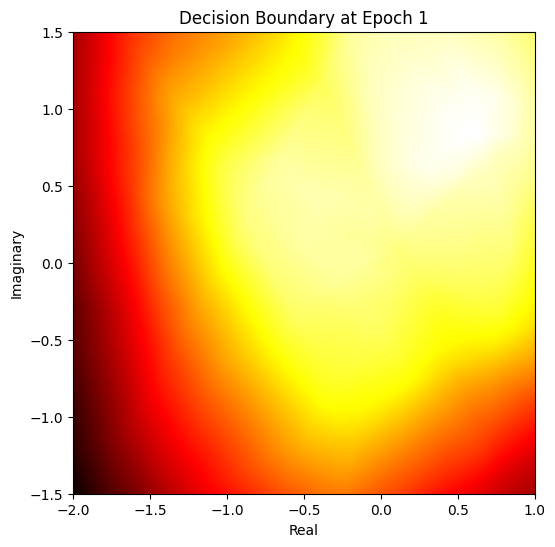

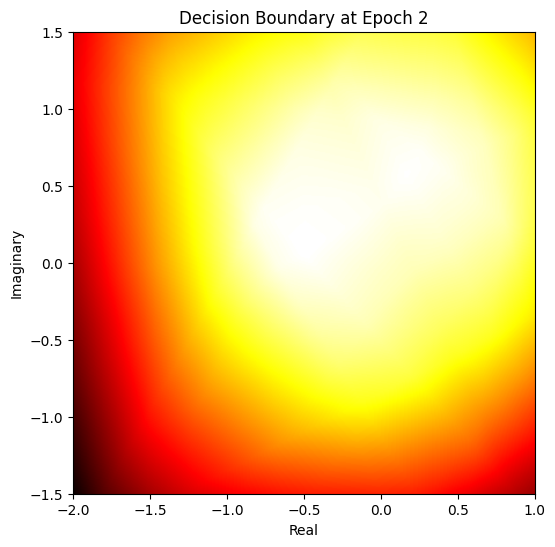

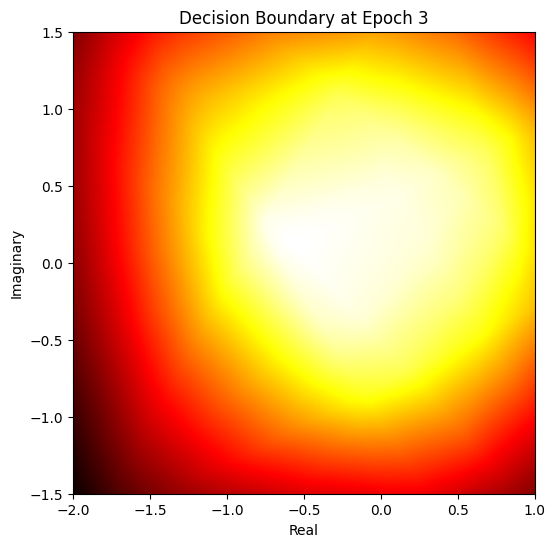

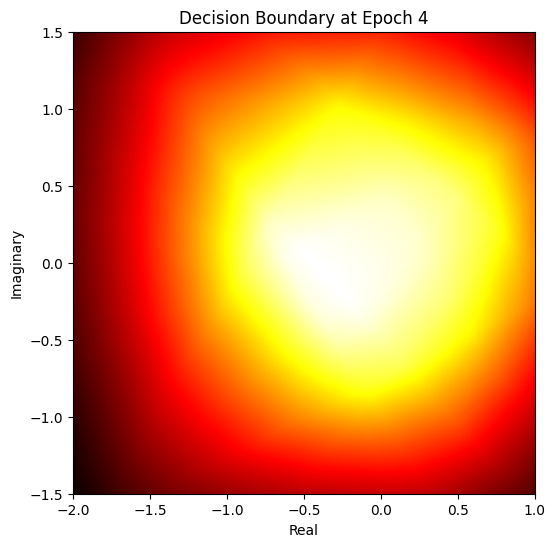

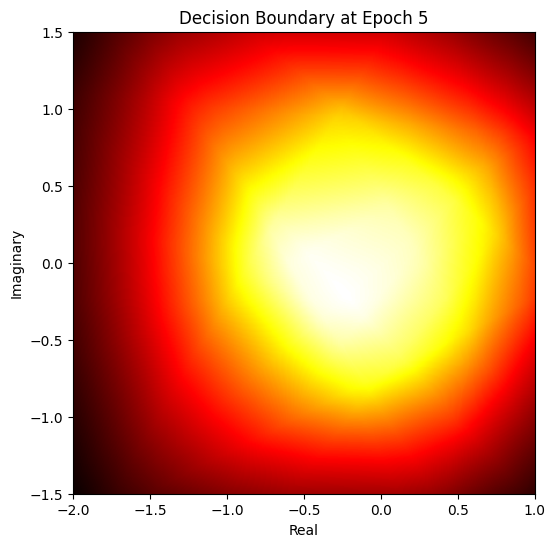

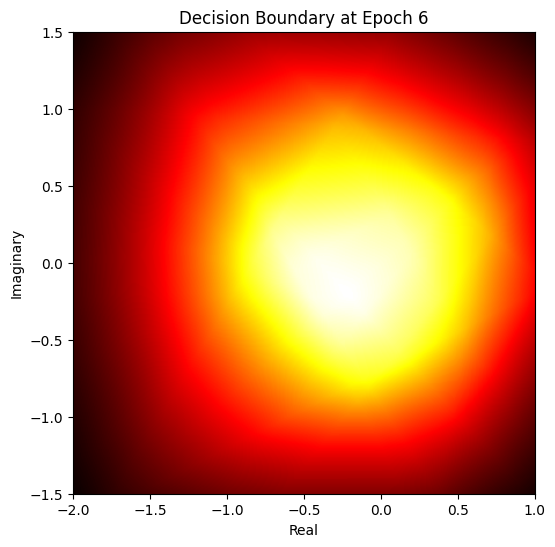

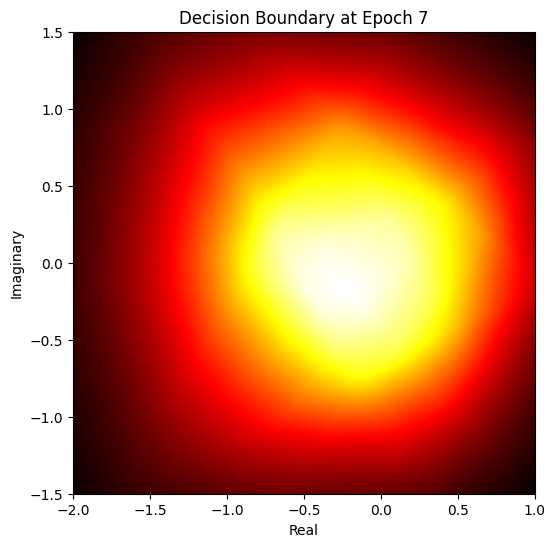

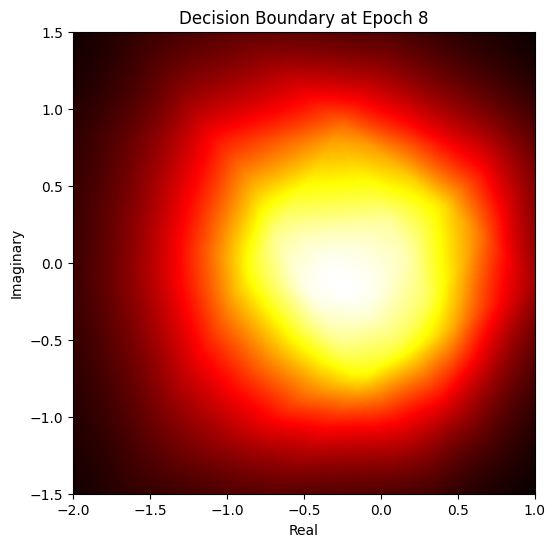

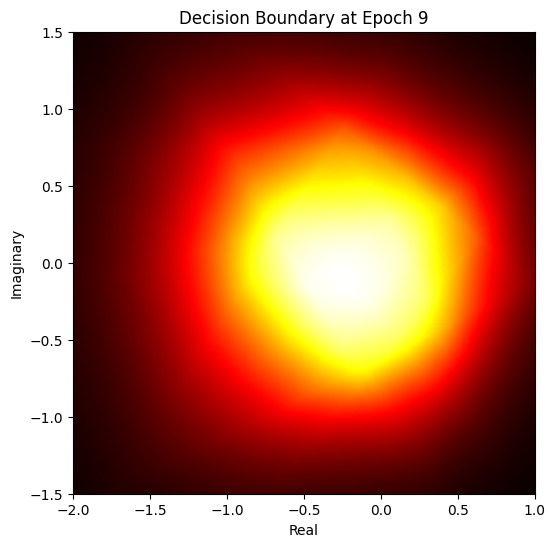

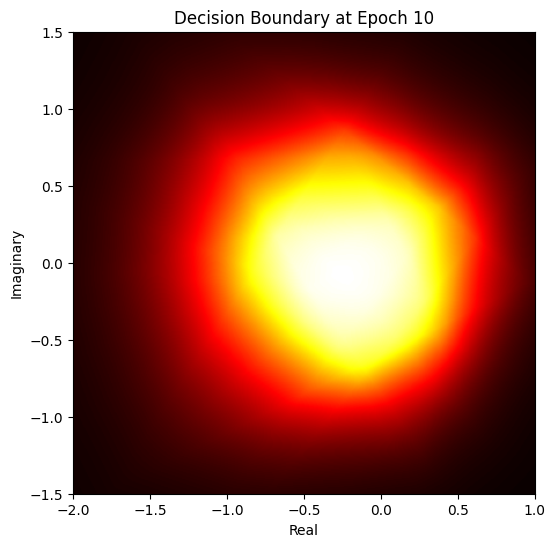

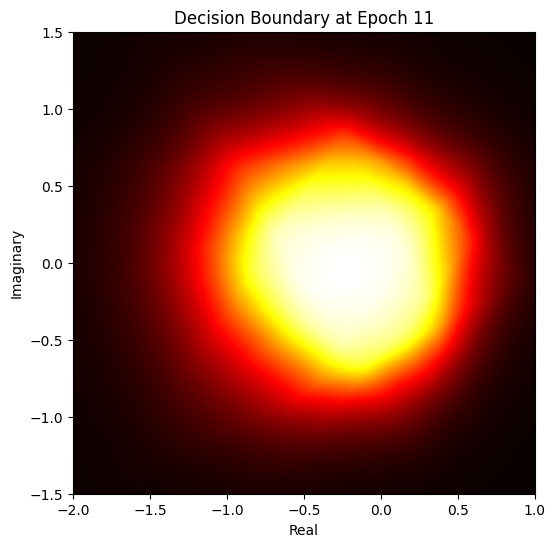

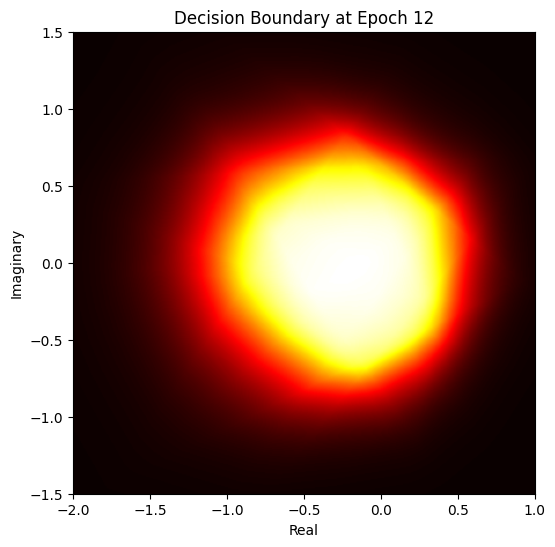

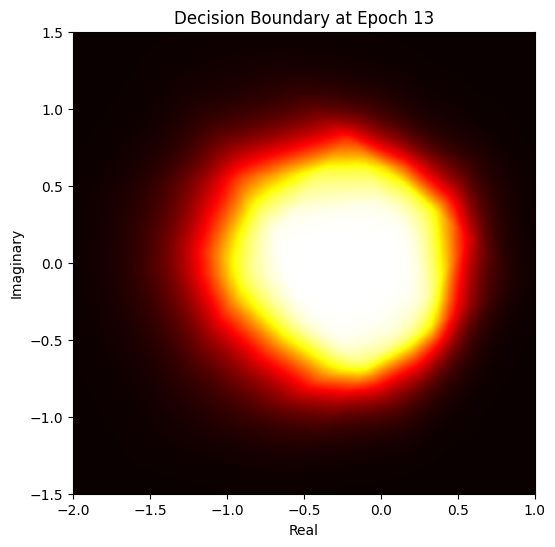

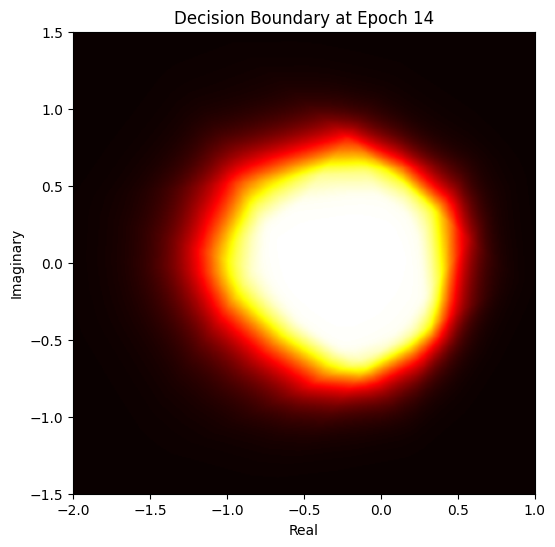

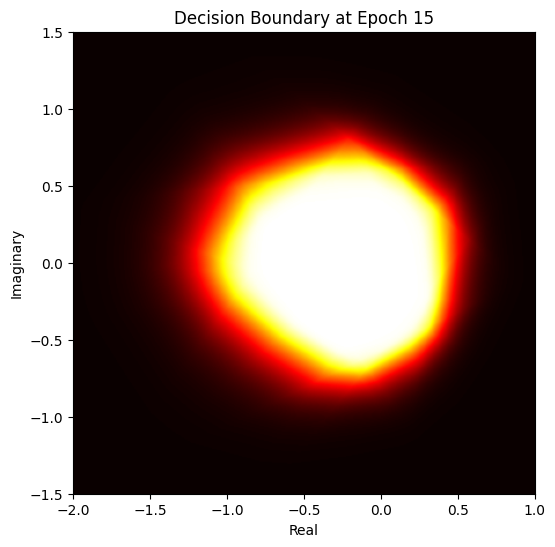

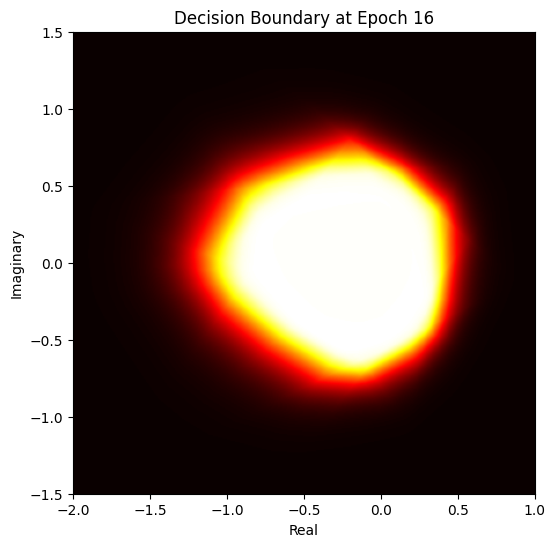

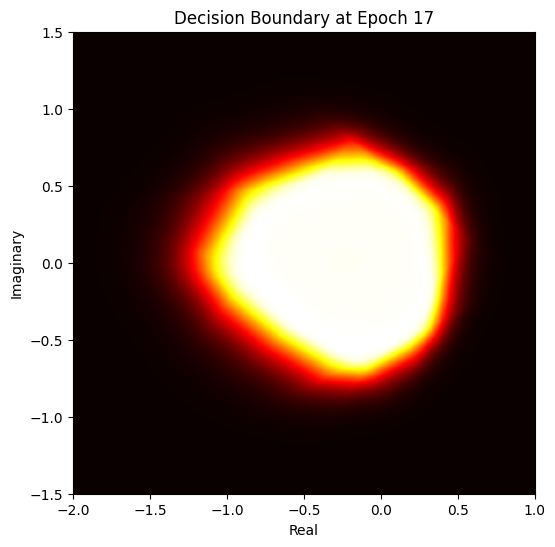

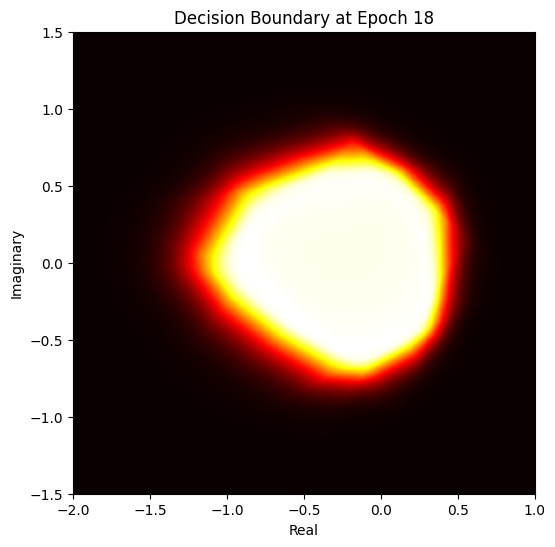

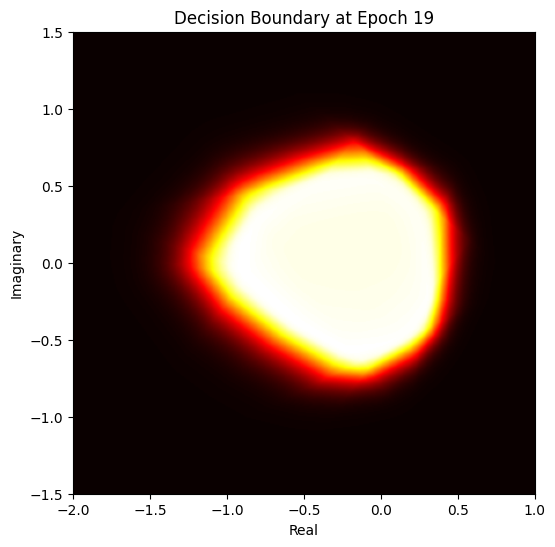

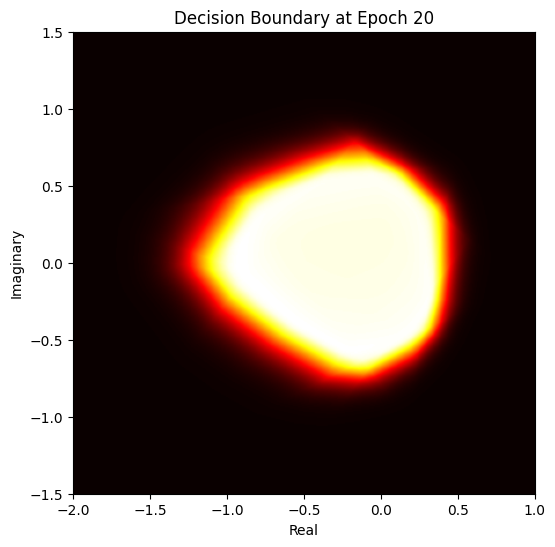

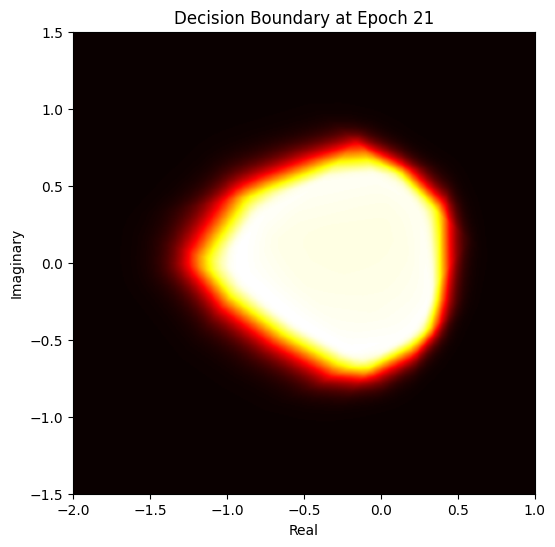

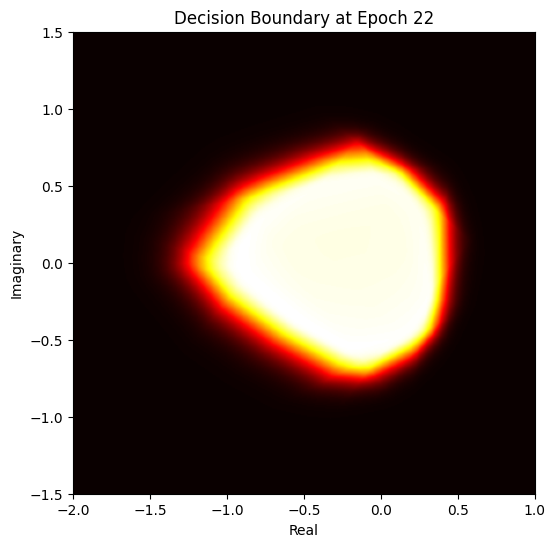

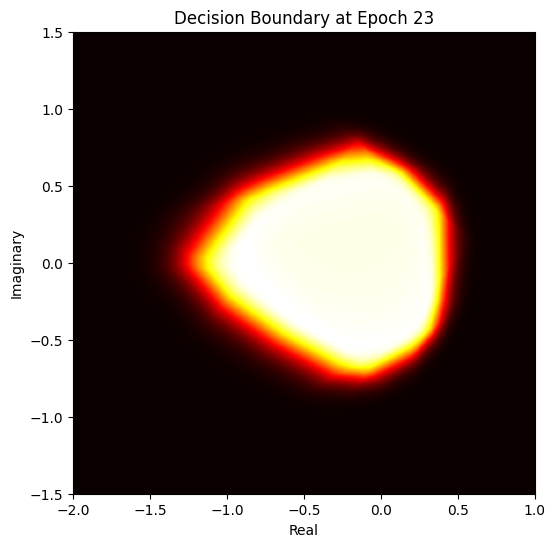

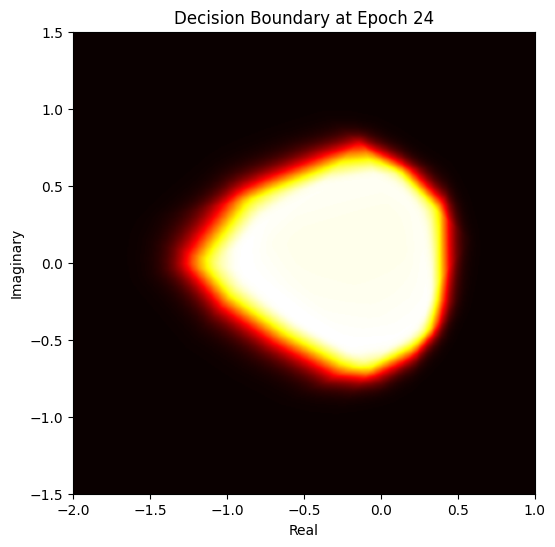

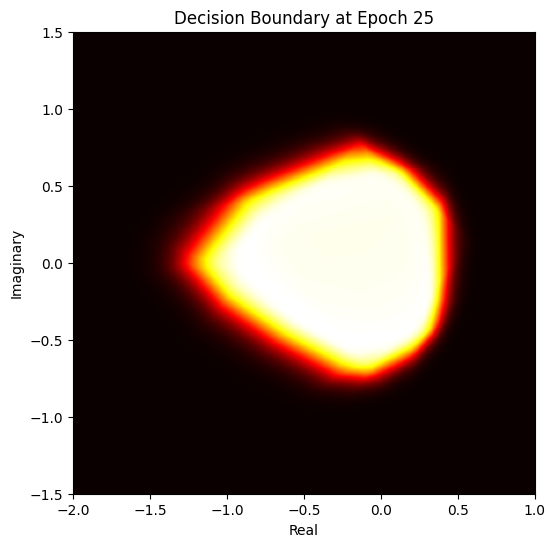

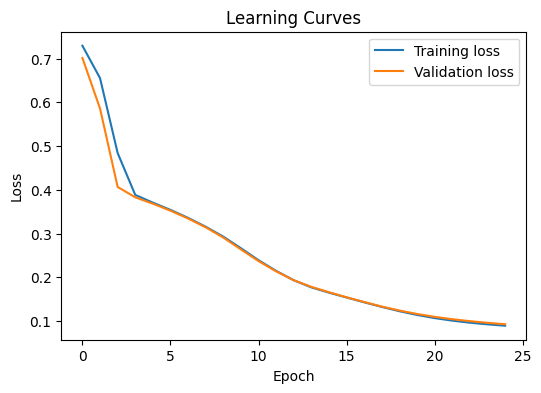


Visualization complete!


In [30]:
# 1. Initialize the model you want to visualize
vis_model = NeuralNet(num_hidden_layers=5)

# 2. Call the new training function
print("--- Training and Generating Visualization ---")
# This will save an image at epochs 5, 10, 15, 20, and 25.
trained_vis_model = train(
    vis_model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epoch=25,
    visualize=True
)

print("\nVisualization complete!")